In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif 
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
connection_args = {
    'host': 'localhost', 
    'dbname': 'jubmam',    
    'port': 5432          
}

connection = pg.connect(**connection_args)

In [3]:
query = "SELECT * FROM cancerdata;"

df = pd.read_sql(query, connection)
df

,Patient_Id,Age,Gender,Air_Pollution,Alcohol_use,Dust_Allergy,OccuPational_Hazards,Genetic_Risk,chronic_Lung_Disease,Balanced_Diet,...,Fatigue,Weight_Loss,Shortness_of_Breath,Wheezing,Swallowing_Difficulty,Clubbing_of_Finger_Nails,Frequent_Cold,Dry_Cough,Snoring,Level
0,P1,33,1,2,4,5,4,3,2,2,...,3,4,2,2,3,1,2,3,4,Low
1,P10,17,1,3,1,5,3,4,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,P100,35,1,4,5,6,5,5,4,6,...,8,7,9,2,1,4,6,7,2,High
3,P1000,37,1,7,7,7,7,6,7,7,...,4,2,3,1,4,5,6,7,5,High
4,P101,46,1,6,8,7,7,7,6,7,...,3,2,4,1,4,2,4,2,3,High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,P995,44,1,6,7,7,7,7,6,7,...,5,3,2,7,8,2,4,5,3,High
996,P996,37,2,6,8,7,7,7,6,7,...,9,6,5,7,2,4,3,1,4,High
997,P997,25,2,4,5,6,5,5,4,6,...,8,7,9,2,1,4,6,7,2,High
998,P998,18,2,6,8,7,7,7,6,7,...,3,2,4,1,4,2,4,2,3,High


In [4]:
def idcleaner(id):
    id = id[1:]
    return int(id)

def dummylevel(level):
    if level == 'High':
        return 2
    elif level == 'Medium':
        return 1
    else:
        return 0


In [5]:
df['Patient_Id'] = df['Patient_Id'].apply(idcleaner)
df['Level'] = df['Level'].apply(dummylevel)
df = df.sort_values(by = ['Patient_Id'])
df['Level'].value_counts()  # Classes are balanced

2    365
1    332
0    303
Name: Level, dtype: int64

In [6]:
X = df.iloc[:,:-1]
y = df['Level']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 30)

In [34]:
nb = MultinomialNB()
nb.fit(X_train,y_train)
print("Naive Bayes Multinomial score: {:6.2f}".format(nb.score(X_test,y_test)))

dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
print("Decision Tree score: {:6.2f}".format(dt.score(X_test,y_test)))

linearsvc = LinearSVC()
linearsvc.fit(X_train,y_train)
print("LinearSVC score: {:6.2f}".format(linearsvc.score(X_test,y_test)))

svc = SVC(kernel='poly', gamma='auto')
svc.fit(X_train,y_train)
print("SVC: {:6.2f}".format(svc.score(X_test,y_test)))

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train,y_train)
print("RandomForest: {:6.2f}".format(rf.score(X_test,y_test)))

Naive Bayes Multinomial score:   0.93
Decision Tree score:   1.00
LinearSVC score:   1.00
SVC:   1.00
RandomForest:   1.00


/Users/jubmam/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [9]:
KNN_parameters = {'n_neighbors': np.arange(1,31,1)}
grid_search = GridSearchCV(estimator=KNeighborsClassifier(), param_grid = KNN_parameters, cv=10, scoring='accuracy', verbose = 0, n_jobs = -1)
grid_search.fit(X, y)
print("Outcomes from the Best KNN Regression Model:")
print("Closest Neighbor Accuracy:", grid_search.best_score_.round(3))
print("The optimal n:", grid_search.best_params_['n_neighbors'])

Outcomes from the Best KNN Regression Model:
Closest Neighbor Accuracy: 0.499
The optimal n: 4


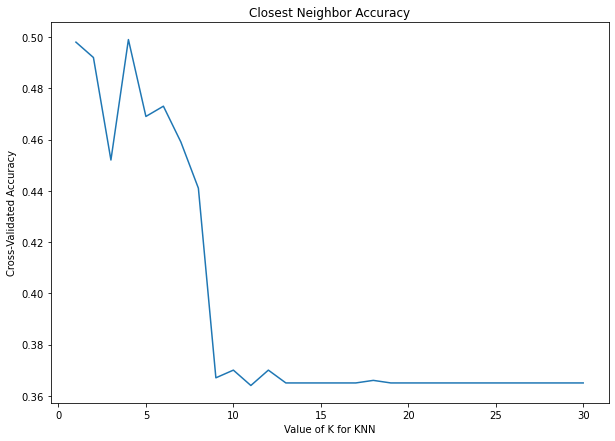

In [10]:
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
fig, ax = plt.subplots(figsize = (10,7))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.title('Closest Neighbor Accuracy');

In [11]:
knn = KNeighborsClassifier(n_neighbors = 4)
knn.fit(X_train, y_train)
kpredict = knn.predict(X_test)
print("The score for kNN is")
print("Training: {:6.2f}%".format(100*knn.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*knn.score(X_test, y_test)))

The score for kNN is
Training:  92.50%
Test set:  79.50%


In [12]:
logit = LogisticRegression(C = 0.95)
logit.fit(X_train, y_train)
lpredict = logit.predict(X_test)
print("The score for logistic regression is")
print("Training: {:6.2f}%".format(100*logit.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*logit.score(X_test, y_test)))

The score for logistic regression is
Training:  90.00%
Test set:  86.50%


/Users/jubmam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


kNN confusion matrix: 
 [[60  0  0]
 [16 33  8]
 [ 1 16 66]]
              precision    recall  f1-score   support

           0       0.78      1.00      0.88        60
           1       0.67      0.58      0.62        57
           2       0.89      0.80      0.84        83

    accuracy                           0.80       200
   macro avg       0.78      0.79      0.78       200
weighted avg       0.80      0.80      0.79       200



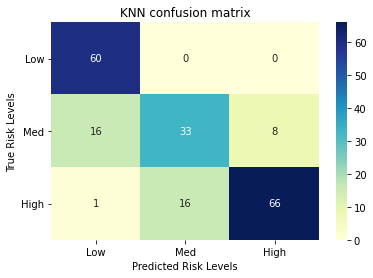

In [13]:
print("kNN confusion matrix: \n", confusion_matrix(y_test, kpredict))
sns.heatmap([[60,  0,  0],
             [16, 33,  8],
             [ 1,  16, 66]], annot = True, cmap="YlGnBu")
plt.title('KNN confusion matrix')
plt.ylabel('True Risk Levels', rotation = 90)
plt.yticks(ticks = [0.5, 1.5, 2.5], labels = ['Low', 'Med', 'High'], rotation = 0)
plt.xticks(ticks = [0.5, 1.5, 2.5], labels = ['Low', 'Med', 'High'], rotation = 0)
plt.xlabel('Predicted Risk Levels')

print(metrics.classification_report(y_test, knn.predict(X_test), labels = [0, 1, 2]))

Logistic confusion matrix: 
 [[49  8  3]
 [ 7 47  3]
 [ 6  0 77]]
Logistic confusion matrix: 

              precision    recall  f1-score   support

           0       0.79      0.82      0.80        60
           1       0.85      0.82      0.84        57
           2       0.93      0.93      0.93        83

    accuracy                           0.86       200
   macro avg       0.86      0.86      0.86       200
weighted avg       0.87      0.86      0.87       200



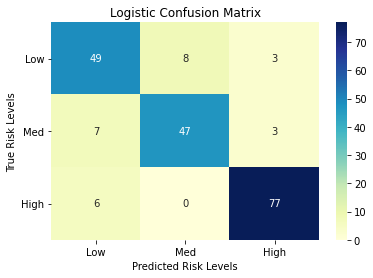

In [14]:
print("Logistic confusion matrix: \n", confusion_matrix(y_test, lpredict))
print("Logistic confusion matrix: \n")
sns.heatmap([[49, 8,  3],
             [ 7, 47, 3],
             [ 6,  0, 77]], annot = True, cmap="YlGnBu")
plt.title('Logistic Confusion Matrix')
plt.ylabel('True Risk Levels', rotation = 90)
plt.yticks(ticks = [0.5, 1.5, 2.5], labels = ['Low', 'Med', 'High'], rotation = 0)
plt.xticks(ticks = [0.5, 1.5, 2.5], labels = ['Low', 'Med', 'High'], rotation = 0)
plt.xlabel('Predicted Risk Levels')

print(metrics.classification_report(y_test, logit.predict(X_test), labels = [0, 1, 2]))

From the three of these factors, we can find three interactions between each of L, M, H

In [15]:
def ishighrisk(input):
    if input < 1:
        return 0
    else:
        return 1

df['High Risk'] = df['Level'].apply(ishighrisk)

In [16]:
X = df.iloc[:,1:-1]
y = df['High Risk']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 30)

lm1 = LogisticRegression(solver= 'liblinear', C=0.95)

train_df = X_train.copy()
train_df['High Risk'] = y_train

low_mask = (train_df['Level'] == 0).values
med_mask = (train_df['Level'] == 1).values
high_mask = (train_df['Level'] == 2).values

lm1.fit(train_df[['Obesity']], y_train)

LogisticRegression(C=0.95, solver='liblinear')

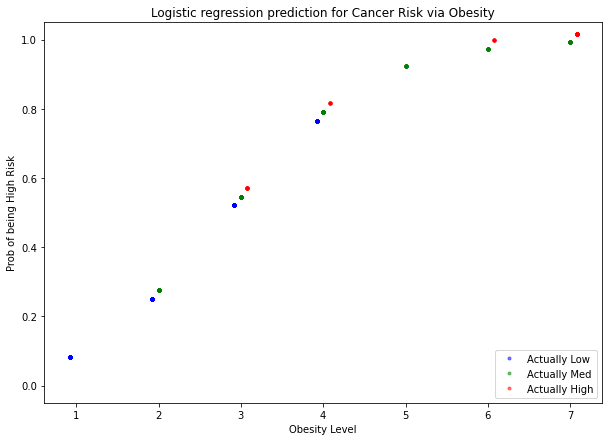

In [17]:
feature = train_df[['Obesity']].values
prediction_hard = lm1.predict(feature)
prediction_soft = lm1.predict_proba(feature)[:, 1]

xlowjitter =  - 0.08
xmedjitter = 0
xhighjitter =  + 0.08

ylowjitter =  - 0.025
ymedjitter =   0
yhighjitter =  + 0.025

fig, ax = plt.subplots(figsize = (10,7))
plt.plot(feature[low_mask] + xlowjitter, prediction_soft[low_mask] + ylowjitter, 'b.', label = 'Actually Low', alpha=0.5)
plt.plot(feature[med_mask] + xmedjitter, prediction_soft[med_mask] + ymedjitter, 'g.', label = 'Actually Med', alpha=0.5)
plt.plot(feature[high_mask] + xhighjitter, prediction_soft[high_mask] + yhighjitter, 'r.',label = 'Actually High', alpha=0.5)
plt.ylim(-0.05, 1.05)
plt.xlabel('Obesity Level')
plt.ylabel('Prob of being High Risk')
plt.legend(loc='lower right')
plt.title('Logistic regression prediction for Cancer Risk via Obesity');

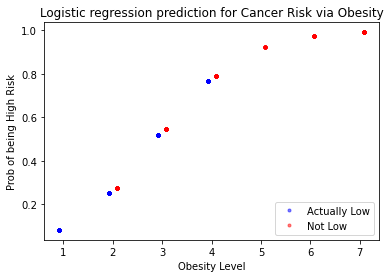

In [18]:
plt.plot(feature[low_mask] + xlowjitter, prediction_soft[low_mask] + ylowjitter, 'b.', label = 'Actually Low', alpha=0.5)
plt.plot(feature[~low_mask] + xhighjitter, prediction_soft[~low_mask] + ymedjitter, 'r.', label = 'Not Low', alpha=0.5)

plt.xlabel('Obesity Level')
plt.ylabel('Prob of being High Risk')
plt.legend(loc='lower right')
plt.title('Logistic regression prediction for Cancer Risk via Obesity');

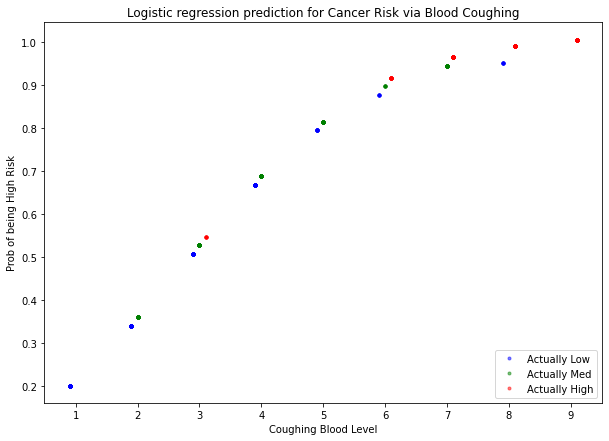

In [19]:
lm1two = LogisticRegression(solver= 'liblinear', C=0.95)
lm1two.fit(train_df[['Coughing_of_Blood']], y_train)

featuretwo = train_df[['Coughing_of_Blood']].values
prediction_hard = lm1two.predict(featuretwo)
prediction_soft = lm1two.predict_proba(featuretwo)[:, 1]

xlowjitter = - 0.1
xmedjitter = 0 
xhighjitter = + 0.1

ylowjitter = - 0.020
ymedjitter = 0
yhighjitter = + 0.020

fig, ax = plt.subplots(figsize = (10,7))
plt.plot(featuretwo[low_mask] + xlowjitter, prediction_soft[low_mask] + ylowjitter, 'b.', label = 'Actually Low', alpha=0.5)
plt.plot(featuretwo[med_mask] + xmedjitter, prediction_soft[med_mask] + ymedjitter, 'g.', label = 'Actually Med', alpha=0.5)
plt.plot(featuretwo[high_mask] + xhighjitter, prediction_soft[high_mask] + yhighjitter, 'r.',label = 'Actually High', alpha=0.5)
plt.xlabel('Coughing Blood Level')
plt.ylabel('Prob of being High Risk')
plt.xticks(np.arange(1,10))
plt.legend(loc='lower right')
plt.title('Logistic regression prediction for Cancer Risk via Blood Coughing');

I did some jittering so that you could actually see if there were some overlaps since  
all the points were originally overlapping so hard you couldn't see a single thing.  
Blue is Actually Low Risk 
Green is Actually Medium Risk
Red is Actually High Risk  

In [20]:
def binarizelow(level):
    if level == 0:
        return 1
    else:
        return 0

def binarizemed(level):
    if level == 1:
        return 1
    else:
        return 0
    
def binarizehigh(level):
    if level == 2:
        return 1
    else:
        return 0

dfcopyone = df.copy()
dfcopytwo = df.copy()

df['Level'] = df['Level'].apply(binarizelow)
dfcopyone['Level'] = dfcopyone['Level'].apply(binarizemed)
dfcopytwo['Level'] = dfcopytwo['Level'].apply(binarizehigh)

Xlow = df.iloc[:,:-1]
ylow = df['Level']
Xmed = dfcopyone.iloc[:,:-1]
ymed = dfcopyone['Level']
Xhigh = dfcopytwo.iloc[:,:-1]
yhigh = dfcopytwo['Level']

In [21]:
X_train_low, X_test_low, y_train_low, y_test_low = train_test_split(Xlow, ylow, test_size= 0.2, random_state= 20)

knnlow = KNeighborsClassifier(n_neighbors = 2)

knnlow.fit(X_train_low, y_train_low)
kpredictlow = knnlow.predict(X_test_low)

logitlow = LogisticRegression(C = 0.95)
logitlow.fit(X_train_low, y_train_low)
lpredictlow = logitlow.predict(X_test_low)

print('---LOW---')
print("kNN confusion matrix: \n", confusion_matrix(y_test_low, kpredictlow))
print("Logistic confusion matrix: \n", confusion_matrix(y_test_low, lpredictlow))



X_train_med, X_test_med, y_train_med, y_test_med = train_test_split(Xmed, ymed, test_size= 0.2, random_state= 20)

knnmed = KNeighborsClassifier(n_neighbors = 2)

knnmed.fit(X_train_med, y_train_med)
kpredictmed = knnmed.predict(X_test_med)

logitmed = LogisticRegression(C = 0.95)
logitmed.fit(X_train_med, y_train_med)
lpredictmed = logitmed.predict(X_test_med)

print('---MED---')
print("kNN confusion matrix: \n", confusion_matrix(y_test_med, kpredictmed))
print("Logistic confusion matrix: \n", confusion_matrix(y_test_med, lpredictmed))



X_train_high, X_test_high, y_train_high, y_test_high = train_test_split(Xhigh, yhigh, test_size= 0.2, random_state= 20)

knnhigh = KNeighborsClassifier(n_neighbors = 2)

knnhigh.fit(X_train_high, y_train_high)
kpredicthigh = knnhigh.predict(X_test_high)

logithigh = LogisticRegression(C = 0.95)
logithigh.fit(X_train_high, y_train_high)
lpredicthigh = logithigh.predict(X_test_high)

print('---HIGH--')
print("kNN confusion matrix: \n", confusion_matrix(y_test_high, kpredicthigh))
print("Logistic confusion matrix: \n", confusion_matrix(y_test_high, lpredicthigh))

---LOW---
kNN confusion matrix: 
 [[136   1]
 [ 15  48]]
Logistic confusion matrix: 
 [[137   0]
 [  0  63]]
---MED---
kNN confusion matrix: 
 [[139   2]
 [ 27  32]]
Logistic confusion matrix: 
 [[129  12]
 [  3  56]]
---HIGH--
kNN confusion matrix: 
 [[116   6]
 [ 24  54]]
Logistic confusion matrix: 
 [[122   0]
 [  0  78]]


/Users/jubmam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jubmam/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

So... about Precision and Recall. We don't want false negatives, since this is a life or death situation  
But we are ok with false positives, since that test can easily be verified with a more technical second opinion, but it could be an unecessary use of medical resources and costs. In this instance, we value recall over precision, so a lower probability threshold is acceptable. Let's take a look only at high risk cases.

In [22]:
print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test_high, kpredicthigh), 
                                                     recall_score(y_test_high, kpredicthigh)))

print("Default threshold:")
print("Precision: {:6.4f},   Recall: {:6.4f}".format(precision_score(y_test_high, lpredicthigh), 
                                                     recall_score(y_test_high, lpredicthigh)))

Default threshold:
Precision: 0.9000,   Recall: 0.6923
Default threshold:
Precision: 1.0000,   Recall: 1.0000


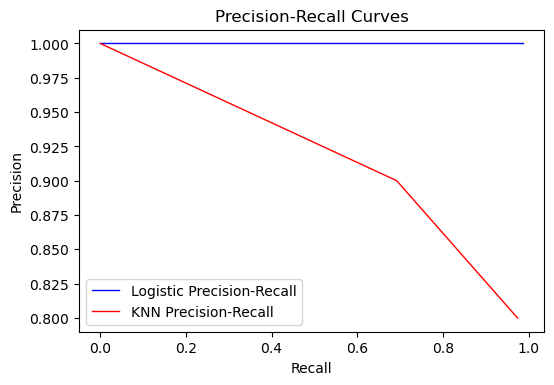

In [23]:
precision_curvek, recall_curvek, threshold_curvek = precision_recall_curve(y_test_high, knnhigh.predict_proba(X_test_high)[:,1] )
precision_curvel, recall_curvel, threshold_curvel = precision_recall_curve(y_test_high, logithigh.predict_proba(X_test_high)[:,1] )

plt.figure(dpi=100)
plt.plot(recall_curvel[1:], precision_curvel[1:], label='Logistic Precision-Recall', lw=1, c = 'b')
plt.plot(recall_curvek[1:], precision_curvek[1:], label='KNN Precision-Recall', lw=1, c = 'r')
plt.legend(loc='lower left')
plt.xlabel('Recall');
plt.ylabel("Precision")
plt.title('Precision-Recall Curves');

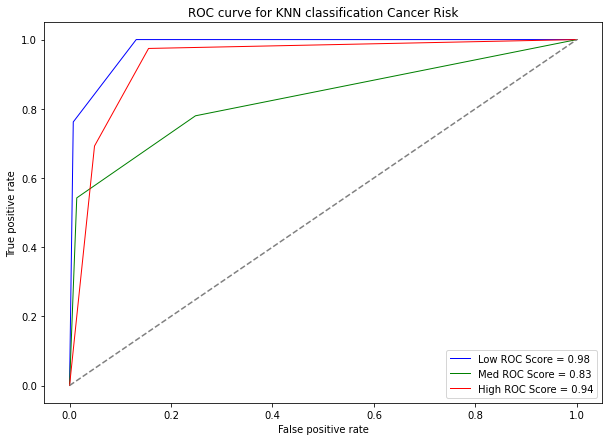

In [24]:
fprl, tprl, thresholdsl = roc_curve(y_test_low, knnlow.predict_proba(X_test_low)[:,1])
fprm, tprm, thresholdsm = roc_curve(y_test_med, knnmed.predict_proba(X_test_med)[:,1])
fprh, tprh, thresholdsh = roc_curve(y_test_high, knnhigh.predict_proba(X_test_high)[:,1])

fig, ax = plt.subplots(figsize = (10,7))
plt.plot(fprl, tprl, lw=1, label = "Low ROC Score = 0.98", c = 'b')
plt.plot(fprm, tprm, lw=1, label = "Med ROC Score = 0.83", c = 'g')
plt.plot(fprh, tprh, lw=1, label = "High ROC Score = 0.94", c = 'r')

plt.plot([0,1],[0,1],c='gray',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc = "lower right")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for KNN classification Cancer Risk');

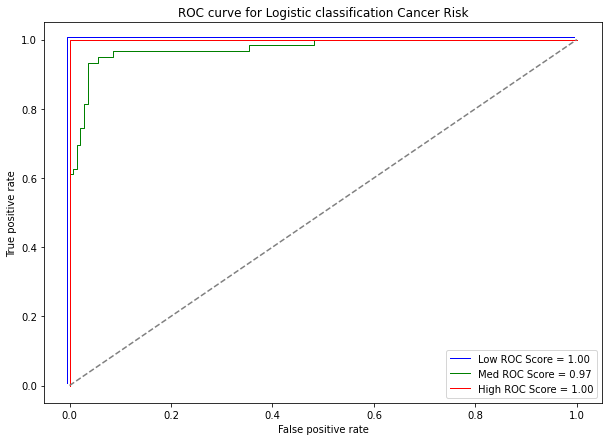

In [25]:
fprl, tprl, thresholdsl = roc_curve(y_test_low, logitlow.predict_proba(X_test_low)[:,1])
fprm, tprm, thresholdsm = roc_curve(y_test_med, logitmed.predict_proba(X_test_med)[:,1])
fprh, tprh, thresholdsh = roc_curve(y_test_high, logithigh.predict_proba(X_test_high)[:,1])

fig, ax = plt.subplots(figsize = (10,7))
plt.plot(fprl-0.005, tprl+0.007, lw=1, label = "Low ROC Score = 1.00", c = 'b')
plt.plot(fprm, tprm, lw=1, label = "Med ROC Score = 0.97", c = 'g')
plt.plot(fprh, tprh, lw=1, label = "High ROC Score = 1.00", c = 'r')

plt.plot([0,1],[0,1],c='gray',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.legend(loc = "lower right")

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Logistic classification Cancer Risk');

In [26]:
connection_args = {
    'host': 'localhost', 
    'dbname': 'jubmam',    
    'port': 5432          
}

connection = pg.connect(**connection_args)

query = "SELECT * FROM cancerdata;"

df = pd.read_sql(query, connection)

Text(0, 0.5, 'Features')

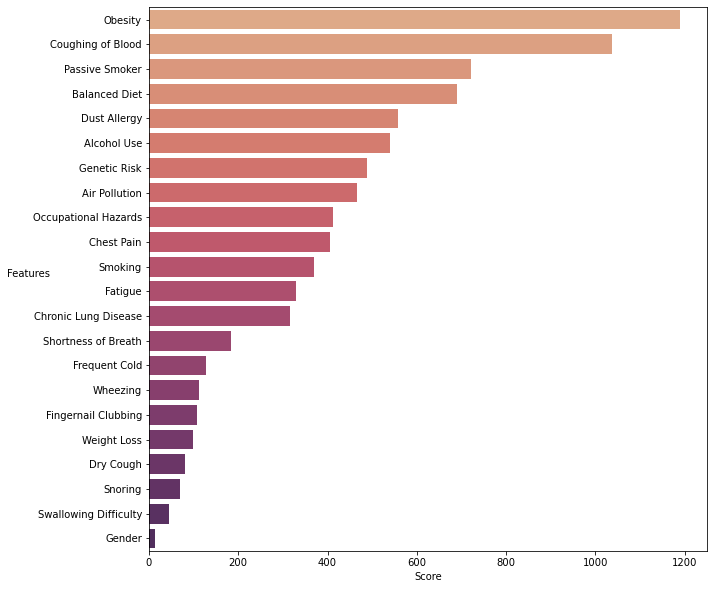

In [27]:
xgraph = df.drop(['Level','Patient_Id'], axis = 1)
xgraph = xgraph.rename(columns = {'Air_Pollution': "Air Pollution", 'Alcohol_use': "Alcohol Use", 'Dust_Allergy': 'Dust Allergy',
       'OccuPational_Hazards': 'Occupational Hazards', 'Genetic_Risk': 'Genetic Risk', 'chronic_Lung_Disease': 'Chronic Lung Disease',
       'Balanced_Diet': 'Balanced Diet','Passive_Smoker': 'Passive Smoker', 'Chest_Pain': 'Chest Pain',
       'Coughing_of_Blood': 'Coughing of Blood', 'Weight_Loss': 'Weight Loss', 'Shortness_of_Breath': 'Shortness of Breath',
       'Swallowing_Difficulty': 'Swallowing Difficulty', 'Clubbing_of_Finger_Nails': 'Fingernail Clubbing',
       'Frequent_Cold': 'Frequent Cold', 'Dry_Cough': 'Dry Cough'})



ygraph = df['Level']
bestfeatures = SelectKBest(score_func = f_classif, k='all')
fit = bestfeatures.fit(xgraph, ygraph)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(xgraph.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Feature','Score']
featureScores = featureScores.sort_values(by = ['Score'], ascending = False)
featureScores = featureScores.iloc[:-1,:]
fig, ax = plt.subplots(figsize = (10,10))
plot = sns.barplot(data = featureScores, x = 'Score', y = 'Feature', palette = 'flare', orient = 'h')
plt.ylabel('Features', rotation = 0)

Text(0, 0.5, 'Features')

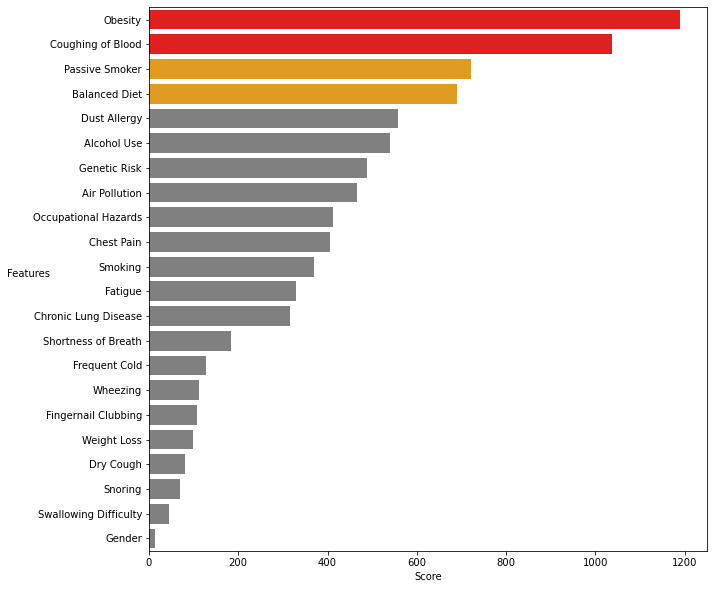

In [28]:
color = ['r', 'r', 'orange','orange','gray','gray','gray','gray','gray',
                   'gray','gray','gray','gray','gray','gray','gray',
                   'gray','gray','gray','gray','gray','gray']
fig, ax = plt.subplots(figsize = (10,10))
plot = sns.barplot(data = featureScores, x = 'Score', y = 'Feature', palette = color, orient = 'h')
plt.ylabel('Features', rotation = 0)

In [29]:
with open('log.pickle', 'wb') as to_write:
    pickle.dump(logit, to_write)